In [1]:
#For analysis purposes, I'd like to store data for each tuner in a pandas DataFrame object.
#Here I will try a rudimentary analysis approach. The three critical measurements are:
#-Top Distance, -Bottom Distance, -Local Board Position
#For the sake of this exercise, I will assume that the local board position is zero for all measurements, i.e. that
#the board has been arranged and calibrated properly.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import numpy as np

Text(0.5, 1.0, 'Sample Profile, 0.75in. Tuner w/o Hole')

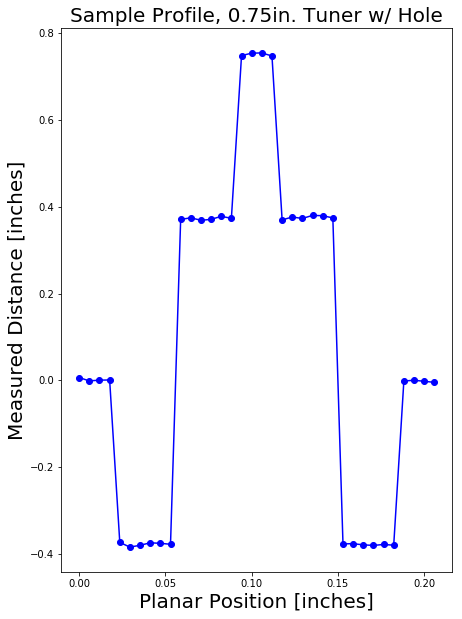

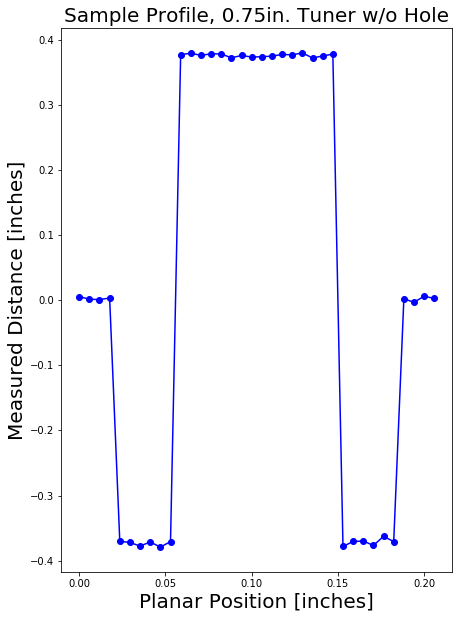

In [3]:
#Re-Creating the two noisy mock measurements from the Sample_Data notebook
#baseline data, for general shape
heights = [0,0,-1,-1,-1,1,1,1,2,2,1,1,1,-1,-1,-1,0,0]
heights_2 = [0,0,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,0,0]
pos = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
heights_p = []
heights_p2 = []
pos_p = []
#increasing data density
for i in range(len(heights)):
    heights_p.append(heights[i])
    heights_p.append(heights[i])
    heights_p2.append(heights_2[i])
    heights_p2.append(heights_2[i])
    pos_p.append(pos[i])
    pos_p.append(pos[i]+1/2)
#adding data to DF object and scaling appropriately
df1 = pd.DataFrame({'heights':heights_p,'position':pos_p})
df2 = pd.DataFrame({'heights':heights_p2,'position':pos_p})
df1['position']=df1['position']*(0.2/17)
df1['heights']=df1['heights']*(0.75/2)
df2['position']=df2['position']*(0.2/17)
df2['heights']=df2['heights']*(0.75/2)
#Instead of the sensor resolution uncertainty, I will be using the global measurement uncertainty of 0.0033 inches
#find resolution uncertainty using standard estimate method
res_u = 0.0033
#update all measurement distances with normal distribution to simulate sensor noise
norm_err_pos1 = []
norm_err_pos2 = []
for i in range(len(df1['heights'])):
    norm_err_pos1.append(np.random.normal(loc=df1['heights'][i],scale=res_u))
    norm_err_pos2.append(np.random.normal(loc=df2['heights'][i],scale=res_u))
df3 = pd.DataFrame({'heights':norm_err_pos1,'position':df1['position']})
df4 = pd.DataFrame({'heights':norm_err_pos2,'position':df1['position']})
#Plotting the profiles with simulated noise
fig1n = plt.figure(figsize=(7,10))
plt.plot(df3['position'],df3['heights'],'bo',linestyle = '-')
plt.xlabel('Planar Position [inches]',fontsize=20)
plt.ylabel('Measured Distance [inches]',fontsize=20)
plt.title('Sample Profile, 0.75in. Tuner w/ Hole',fontsize=20)

fig2n = plt.figure(figsize=(7,10))
plt.plot(df4['position'],df4['heights'],'bo',linestyle = '-')
plt.xlabel('Planar Position [inches]',fontsize=20)
plt.ylabel('Measured Distance [inches]',fontsize=20)
plt.title('Sample Profile, 0.75in. Tuner w/o Hole',fontsize=20)

In [4]:
#Unit Testing the Solution: Part 1: Identifying the set of points belonging to the top of the tuner.
def find_top(tuner):
    abs_min = min(tuner['heights'])
    min_set = []
    for i in range(len(tuner['heights'])):
        #Using an effective 2-sigma approach, assuming the absolute minimum could be at most 2-sigma from the mean
        if tuner['heights'][i] < (abs_min+4*res_u):
            min_set.append(tuner['heights'][i])
    return(np.average(min_set))
print(find_top(df3))
print(find_top(df4))

-0.37710410262350935
-0.373264715989184


In [44]:
#Unit Testing Part 2: Identifying whether the tuner has a hole punched in the bottom
def punch_check(tuner):
    #Returns True if there's a hole punched in the bottom, False otherwise
    abs_max = max(tuner['heights'])
    if abs_max > (1.25+2*res_u):
        return True
    #identifying a tuner-top point to start iteration
    abs_min = min(tuner['heights'])
    start_ind = 0
    for i in range(len(tuner['heights'])):
        if tuner['heights'][i] < (abs_min+4*res_u):
            start_ind = i
            break
    #pruning the data set, assuming symmetry
    tuner_well = tuner['heights'][start_ind:(len(tuner['heights'])-start_ind)]
    #Checking for the number of large discontinuities, or "jumps", in the tuner well set.
    #The smallest tuner size is 0.4''
    #A jump is "large" if it is greater than half of this value.
    jump_count = 0
    i=start_ind
    while i < (len(tuner_well)+start_ind-1):
        if abs(tuner_well[i+1]-tuner_well[i])>(0.4/2):
            jump_count += 1
        i+=1
    if jump_count > 2:
        return True
    else:
        return False
print(punch_check(df3))
print(punch_check(df4))

True
False


In [49]:
#Unit Testing Part 3: Finding the tuner bottom
def find_bottom(tuner):
    if punch_check(tuner):
        #Pruning the data as in punch_check:
        abs_min = min(tuner['heights'])
        start_ind = 0
        for i in range(len(tuner['heights'])):
            if tuner['heights'][i] < (abs_min+4*res_u):
                start_ind = i
                break
        tuner_well = tuner['heights'][start_ind:(len(tuner['heights'])-start_ind)]
        #As in punch_check, we iterate through the "well" data, this time to return the bottom value before 2nd jump
        jump_count = 0
        i=start_ind
        while i < (len(tuner_well)+start_ind-1):
            if abs(tuner_well[i+1]-tuner_well[i])>(0.4/2):
                jump_count += 1
            if jump_count >= 2:
                return tuner_well[i]
            else:
                i+=1
    else:
        return max(tuner['heights'])

#Printing the two test answers
print(find_bottom(df3))
print(find_bottom(df4))
print('\n')
#And the two "correct" answers
print(df3['heights'][15])
print(df4['heights'][17])
print('\n')
#Here's the "wrong" answer for the tuner with the hole (df3) if we were to just take the max
print(max(df3['heights']))

0.3730777916695957
0.3795774385205981


0.3730777916695957
0.3732000136244399


0.7536666466369296
